In [2]:
import os
import sys

sys.path.append("../model")
sys.path.append("..")

import math
import geopandas as gpd
import numpy as np
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import rasterio
from shapely.geometry import box, mapping
from datetime import datetime
import torch
import yaml
from box import Box
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn import decomposition
from torchvision.transforms import v2
from src.model import ClayMAEModule

data_dir = "../data/clay_testing/gdb"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
tiles_geojson_path = "../data/clay_testing/tiles.geojson"

if os.path.exists(tiles_geojson_path):
    # Load existing tiles GeoDataFrame
    tiles_gdf = gpd.read_file(tiles_geojson_path)
else:
    # Generate tiles as before
    county_boundary = gpd.read_file("../data/county_boundary.shp")
    # Reproject to UTM
    county_boundary_utm = county_boundary.to_crs("EPSG:26917")
    
    # Function to generate tiles
    def generate_tiles(geometry, tile_size):
        # Get the bounds of the geometry
        minx, miny, maxx, maxy = geometry.total_bounds
        
        # Generate grid coordinates
        x_coords = np.arange(minx, maxx, tile_size)
        y_coords = np.arange(miny, maxy, tile_size)
        
        tiles = []
        for x in x_coords:
            for y in y_coords:
                # Create a tile as a box (minx, miny, maxx, maxy)
                tile = box(x, y, x + tile_size, y + tile_size)
                # Check if the tile intersects with the geometry
                if tile.intersects(geometry.union_all()):
                    tiles.append(tile)
        return tiles
    
    tile_size = 512  # Tile size in meters
    tiles = generate_tiles(county_boundary_utm, tile_size)
    tiles_gdf = gpd.GeoDataFrame({'geometry': tiles}, crs="EPSG:26917")
    # Add columns for tracking
    tiles_gdf['processed'] = False
    tiles_gdf['data_files'] = [[] for _ in range(len(tiles_gdf))]
    # Save tiles_gdf to GeoJSON
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

c:\Users\bento\gis582\project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping field data_files: unsupported OGR type: 5


In [ ]:
# Dates to query
start = "2021-01-01"
end = "2023-12-31"

# Bands to query
bands = ["red", "green", "blue", "nir"]

# Open the STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

# Function to query STAC items for a tile
def query_stac_tile(tile_geometry, start, end, collections=["naip"], limit=1000):
    # Get the bounds of the tile in WGS84
    tile_wgs84 = gpd.GeoSeries([tile_geometry], crs="EPSG:26917").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = tile_wgs84.bounds
    bbox = [minx, miny, maxx, maxy]
    
    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit
    )
    # Get the items from the search results
    items = list(search.item_collection())

    return items

def get_subregion(dataset, bounds):
    min_x, min_y, max_x, max_y = bounds
    # Subset the dataset using xarray's sel function
    subregion = dataset.sel(
        x=slice(min_x, max_x),  # X-coordinate bounds
        y=slice(max_y, min_y)   # Y-coordinate bounds (flip due to coordinate system)
    )
    return subregion

# Function to get image from item
def get_image_from_item(item, bands, chunk_size=2048, dtype=np.float32, 
                        crs="EPSG:26917", bounds=None):
    # Print item information
    print(f"Found item: {item.id}, Date: {item.datetime}")
    
    # Sign the asset URL
    asset_href = planetary_computer.sign(item.assets["image"].href)
      
    # Open the NAIP image using rioxarray
    with rasterio.Env():
        ds = rioxarray.open_rasterio(
            asset_href,
            chunks={"band": -1, "x": chunk_size, "y": chunk_size},
            lock=False
        ).assign_coords(band=bands).astype(dtype)
    if ds.rio.crs != crs:
        ds = ds.rio.reproject(crs)
    if bounds is not None:
        ds = get_subregion(ds, bounds)
    # Instead of adding 'time' dimension, store time as an attribute
    naive_datetime = item.datetime.replace(tzinfo=None)
    time_value = np.datetime64(naive_datetime, 'ns')
    ds.attrs['time'] = str(time_value)
    return ds

# Function to clean up bounds for filename
def clean_bounds(bounds):
    minx, miny, maxx, maxy = bounds
    # Round to 3 decimal places and remove any special characters
    minx_str = f"{minx:.3f}".replace('.', '_')
    miny_str = f"{miny:.3f}".replace('.', '_')
    maxx_str = f"{maxx:.3f}".replace('.', '_')
    maxy_str = f"{maxy:.3f}".replace('.', '_')
    # Combine into a single string
    bounds_str = f"{minx_str}_{miny_str}_{maxx_str}_{maxy_str}"
    return bounds_str

# Now process the tiles
for idx, tile in tiles_gdf[~tiles_gdf['processed']].iterrows():
    try:
        print(f"Processing tile {idx + 1}/{len(tiles_gdf)}")
        tile_geometry = tile['geometry']
        # Query STAC items for the tile
        tile_items = query_stac_tile(tile_geometry, start, end)
        if tile_items:
            # Collect unique items per date
            unique_items = {}
            for item in tile_items:
                date_str = item.datetime.date().isoformat()
                if date_str not in unique_items:
                    unique_items[date_str] = item
            # Process each unique item
            tile_data_files = []
            tile_bounds = tile_geometry.bounds
            # Clean up the bounds to be suitable for filename
            bounds_str = clean_bounds(tile_bounds)
            for date_str, item in unique_items.items():
                # Define the output file path
                output_file = os.path.join(data_dir, f"tile_{idx}_{bounds_str}_{date_str}.tif")
                if not os.path.exists(output_file):
                    # Download and save the data
                    try:
                        ds = get_image_from_item(item, bands, chunk_size=2048, bounds=tile_bounds)
                        # Save the dataset to a GeoTIFF
                        ds.rio.to_raster(output_file)
                        tile_data_files.append(output_file)
                        print(f"Saved data to {output_file}")
                    except Exception as e:
                        print(f"Error processing item {item.id}: {e}")
                        continue  # Skip this item and move on to the next
                else:
                    tile_data_files.append(output_file)
                    print(f"Data file {output_file} already exists, skipping download")
            # Update the tiles_gdf with data files and set 'processed' to True
            tiles_gdf.at[idx, 'data_files'] = tile_data_files
            tiles_gdf.at[idx, 'processed'] = True
        else:
            # No items found for this tile
            print(f"No items found for tile {idx}")
    except Exception as e:
        # Print error message but skip marking as processed
        print(f"Error processing tile {idx}: {e}")
        continue  # Skip this tile and move on to the next one

    # Save the updated tiles_gdf to 'tiles.geojson'
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')


../data/clay_testing/gdb\tile_266_715942_129_3929444_294_716454_129_3929956_294_2022-09-02.tif


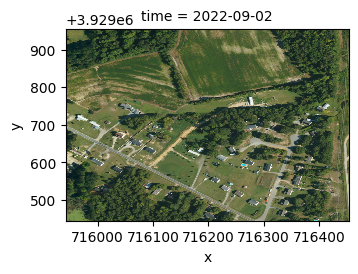

In [14]:
def get_by_idx(tile_idx, tiles_gdf, bands):
    tile_data_files = tiles_gdf.at[tile_idx, 'data_files']
    datasets = []
    for data_file in tile_data_files:
        print(data_file)
        date_str = os.path.splitext(os.path.basename(data_file))[0].split('_')[-1]
        date = np.datetime64(date_str, 'ns')
        ds = rioxarray.open_rasterio(data_file)
        ds = ds.assign_coords(band=bands)
        ds = ds.expand_dims({'time': [date]})
        datasets.append(ds)
    stacked_ds = xr.concat(datasets, dim='time')
    return stacked_ds

stack = get_by_idx(266, tiles_gdf, bands)

stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
)

In [9]:
def get_stack_centroid_lat_lon(stack):
    # Extract the x and y coordinates
    x_coords = stack['x'].values
    y_coords = stack['y'].values
    # Compute the centroid in the dataset's CRS
    x_min = x_coords.min()
    x_max = x_coords.max()
    y_min = y_coords.min()
    y_max = y_coords.max()
    x_centroid = (x_min + x_max) / 2
    y_centroid = (y_min + y_max) / 2
    # Create a GeoDataFrame with the centroid point
    centroid_point = Point(x_centroid, y_centroid)
    gdf = gpd.GeoDataFrame(geometry=[centroid_point], crs=stack.rio.crs)
    # Reproject to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    # Extract latitude and longitude
    lon = gdf_wgs84.geometry.x.values[0]
    lat = gdf_wgs84.geometry.y.values[0]
    return lat, lon

# Use the function on your stack
lat, lon = get_stack_centroid_lat_lon(stack)
print(f'Centroid Latitude: {lat}, Longitude: {lon}')

Centroid Latitude: 35.52137508075878, Longitude: -78.70607440958321


In [6]:
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "../clay-ckpt/clay-v1-base.ckpt"
metadata_path = "configs/metadata.yaml" 
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path=metadata_path, shuffle=False, mask_ratio=0
)

model.eval()
model = model.to(device)

c:\Users\bento\gis582\project\env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
# Extract mean, std, and wavelengths from metadata
platform = "naip"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [10]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]

# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [14]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), 
        dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(0.6, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [15]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

Patches shape: torch.Size([1, 11236, 768])
Grid size: 106


In [ ]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

plt.scatter(stack.time, pca_result, color="green")
